In [ ]:
#| eval false

## Prototyping Aggregations

We're going to learn how to aggregate the exposure data into daily values. This is useful for analyzing the data over a longer period of time, such as a week or a month, and is part of the larger goal of this project to aggregate the ERA5 dataset for Madagascar.


Doing an aggregation of a netcdf file is relatively simple. What we need to do is read in the data, and then use the `xarray` library to group the data by time using a resampler method. We can then use the `mean` function to calculate the average value for each day.


In [8]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pyprojroot import here
from hydra import initialize, compose
from omegaconf import OmegaConf

In [2]:
with initialize(version_base=None, config_path="../conf"):
    cfg = compose(config_name='config.yaml')

In [4]:
# Load the NetCDF file
fpath = here() / "data/input/2010_1.nc"
ds = xr.open_dataset(fpath)

# Perform multiple aggregations
daily_mean = ds.resample(valid_time="1D").mean()  # Daily mean
daily_max = ds.resample(valid_time="1D").max()   # Daily max
daily_min = ds.resample(valid_time="1D").min()   # Daily min

# Combine the results into a new dataset
daily_aggregated = xr.Dataset({
    "t2m_mean": daily_mean["t2m"],
    "t2m_max": daily_max["t2m"],
    "t2m_min": daily_min["t2m"],
    "d2m_mean": daily_mean["d2m"],
    "d2m_max": daily_max["d2m"],
    "d2m_min": daily_min["d2m"]
})

# Save the aggregated dataset to a new NetCDF file (optional)
#daily_aggregated.to_netcdf("daily_aggregated.nc")

# Print the result
print(daily_aggregated)

<xarray.Dataset> Size: 1MB
Dimensions:     (latitude: 59, longitude: 33, valid_time: 31)
Coordinates:
    number      int64 8B 0
  * latitude    (latitude) float64 472B -11.6 -11.85 -12.1 ... -25.85 -26.1
  * longitude   (longitude) float64 264B 42.7 42.95 43.2 ... 50.2 50.45 50.7
  * valid_time  (valid_time) datetime64[ns] 248B 2010-01-01 ... 2010-01-31
Data variables:
    t2m_mean    (valid_time, latitude, longitude) float32 241kB 300.9 ... 297.9
    t2m_max     (valid_time, latitude, longitude) float32 241kB 301.2 ... 299.1
    t2m_min     (valid_time, latitude, longitude) float32 241kB 300.3 ... 296.8
    d2m_mean    (valid_time, latitude, longitude) float32 241kB 297.7 ... 293.1
    d2m_max     (valid_time, latitude, longitude) float32 241kB 298.0 ... 295.8
    d2m_min     (valid_time, latitude, longitude) float32 241kB 297.3 ... 290.2


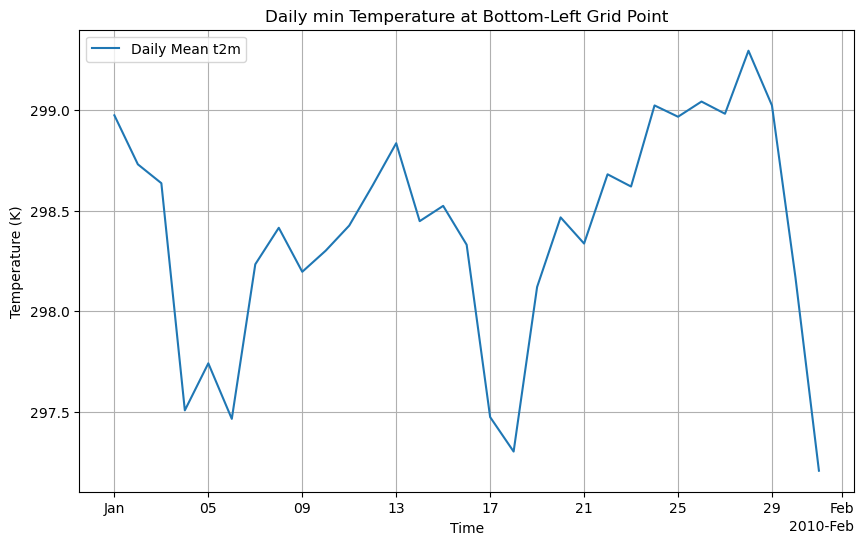

In [7]:
# Select a specific grid point (e.g., latitude=-1, longitude=0)
variable='min'
t2m_mean_point = daily_aggregated["t2m_" + variable].isel(latitude=-1, longitude=0)

# Plot the time series
plt.figure(figsize=(10, 6))
t2m_mean_point.plot(label="Daily Mean t2m")
plt.title("Daily {} Temperature at Bottom-Left Grid Point".format(variable))
plt.xlabel("Time")
plt.ylabel("Temperature (K)")
plt.legend()
plt.grid()
plt.show()

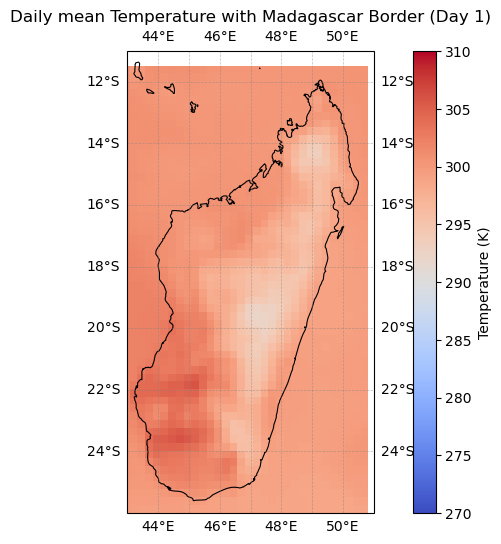

In [94]:
# Select the first day of t2m_mean
variable="mean"
t2m_mean_day1 = daily_aggregated["t2m_" + variable].isel(valid_time=0)

# Set the absolute min and max for the color bar
vmin = 270  # Minimum value (e.g., 270 K)
vmax = 310  # Maximum value (e.g., 310 K)

# Create a plot with Cartopy
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())  # Use PlateCarree projection for latitude/longitude data

# Plot the data
t2m_mean_day1.plot(ax=ax, cmap="coolwarm", transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cbar_kwargs={"label": "Temperature (K)"})

# Add Madagascar's border using Cartopy's built-in features
ax.add_feature(cfeature.BORDERS, edgecolor="black", linewidth=1)  # Add country borders
ax.add_feature(cfeature.COASTLINE, edgecolor="black", linewidth=0.8)  # Add coastlines

# Optionally, zoom in on Madagascar
ax.set_extent([43, 51, -26, -11], crs=ccrs.PlateCarree())  # Longitude and latitude bounds for Madagascar

# Add gridlines
ax.gridlines(draw_labels=True, linewidth=0.5, color="gray", alpha=0.5, linestyle="--")

# Add a title
plt.title("Daily {} Temperature with Madagascar Border (Day 1)".format(variable))
plt.show()

In [14]:
ds['t2m']

<xarray.DataArray 't2m' (valid_time: 744, latitude: 59, longitude: 33)> Size: 6MB
[1448568 values with dtype=float32]
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 6kB 2010-01-01 ... 2010-01-31T23:...
  * latitude    (latitude) float64 472B -11.6 -11.85 -12.1 ... -25.85 -26.1
  * longitude   (longitude) float64 264B 42.7 42.95 43.2 ... 50.2 50.45 50.7
    expver      (valid_time) <U4 12kB ...
Attributes: (12/32)
    GRIB_paramId:                             167
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      1947
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               K
    long_name:                                2 metre temperature
    units:                                    K
    standard_name:                            unknown
    GRIB_surface:                             0.0

In [15]:
ds

<xarray.Dataset> Size: 12MB
Dimensions:     (valid_time: 744, latitude: 59, longitude: 33)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 6kB 2010-01-01 ... 2010-01-31T23:...
  * latitude    (latitude) float64 472B -11.6 -11.85 -12.1 ... -25.85 -26.1
  * longitude   (longitude) float64 264B 42.7 42.95 43.2 ... 50.2 50.45 50.7
    expver      (valid_time) <U4 12kB ...
Data variables:
    d2m         (valid_time, latitude, longitude) float32 6MB ...
    t2m         (valid_time, latitude, longitude) float32 6MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-03-27T17:15 GRIB to CDM+CF via cfgrib-0.9.1...

In [17]:
ds.attrs

{'GRIB_centre': 'ecmf',
 'GRIB_centreDescription': 'European Centre for Medium-Range Weather Forecasts',
 'GRIB_subCentre': np.int64(0),
 'Conventions': 'CF-1.7',
 'institution': 'European Centre for Medium-Range Weather Forecasts',
 'history': '2025-03-27T17:15 GRIB to CDM+CF via cfgrib-0.9.15.0/ecCodes-2.39.0 with {"source": "tmpznyjyhvw/data.grib", "filter_by_keys": {"stream": ["oper"], "stepType": ["instant"]}, "encode_cf": ["parameter", "time", "geography", "vertical"]}'}

In [20]:
import geopandas as gpd
zip_url_or_path = here() / "data/testing/gadm41_MDG.gpkg"

shape = gpd.read_file(zip_url_or_path, layer = "ADM_ADM_1")


The below data is a specification of the polygons that represent geographic boundaries. In a vector the steps between each value are not guaranteed to be equal, so we will then "project" them into a known coordinate reference system.

In [21]:
shape

,GID_1,GID_0,COUNTRY,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,ISO_1,geometry
0,MDG.1_1,MDG,Madagascar,Antananarivo,NA,NA,NA,NA,NA,NA,MG-T,"MULTIPOLYGON (((46.93914 -20.17013, 46.9386 -2..."
1,MDG.2_1,MDG,Madagascar,Antsiranana,NA,NA,NA,NA,NA,NA,MG-D,"MULTIPOLYGON (((50.15347 -16.0032, 50.15347 -1..."
2,MDG.3_1,MDG,Madagascar,Fianarantsoa,NA,NA,NA,NA,NA,NA,MG-F,"MULTIPOLYGON (((47.04934 -24.08504, 47.04925 -..."
3,MDG.4_1,MDG,Madagascar,Mahajanga,NA,NA,NA,NA,NA,NA,MG-M,"MULTIPOLYGON (((44.23931 -18.96421, 44.23931 -..."
4,MDG.5_1,MDG,Madagascar,Toamasina,NA,NA,NA,NA,NA,NA,MG-A,"MULTIPOLYGON (((47.67118 -20.36464, 47.6713 -2..."
5,MDG.6_1,MDG,Madagascar,Toliary,NA,NA,NA,NA,NA,NA,NA,"MULTIPOLYGON (((44.33236 -25.26931, 44.33236 -..."


A quick note about CRS:

The WGS 84 (World Geodetic System 1984) is a widely used global Coordinate Reference System (CRS). It is the standard CRS for GPS (Global Positioning System) and is commonly used in geospatial applications. WGS 84 defines a geographic coordinate system based on a specific ellipsoid model of the Earth.

Key Features of WGS 84
Type: Geographic Coordinate System (GCS).

Coordinates are represented in latitude, longitude, and optionally altitude.
Units: Degrees (for latitude and longitude).
Ellipsoid: WGS 84 uses a reference ellipsoid with:

Semi-major axis: 6,378,137 meters.
Flattening: 1 / 298.257223563.
Datum: The WGS 84 datum defines the origin and orientation of the coordinate system.

EPSG Code: The EPSG code for WGS 84 is 4326.

In [22]:
shape.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

We're pasting in a utility here for finding the intersecting values between our netcdf data and the polygons represented in our shapefile (ie the states, regions, etc.).

Source: https://github.com/NSAPH-Data-Processing/air_pollution__aqdh/blob/main/utils/faster_zonal_stats.py

In [23]:
import numpy as np
from tqdm import tqdm
from math import ceil, floor

from rasterstats.io import Raster
from rasterstats.utils import boxify_points, rasterize_geom

In [24]:
ds['t2m']

<xarray.DataArray 't2m' (valid_time: 744, latitude: 59, longitude: 33)> Size: 6MB
[1448568 values with dtype=float32]
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 6kB 2010-01-01 ... 2010-01-31T23:...
  * latitude    (latitude) float64 472B -11.6 -11.85 -12.1 ... -25.85 -26.1
  * longitude   (longitude) float64 264B 42.7 42.95 43.2 ... 50.2 50.45 50.7
    expver      (valid_time) <U4 12kB ...
Attributes: (12/32)
    GRIB_paramId:                             167
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      1947
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               K
    long_name:                                2 metre temperature
    units:                                    K
    standard_name:                            unknown
    GRIB_surface:                             0.0

In [66]:
def polygon_to_raster_cells(
    vectors,
    raster,
    band=1,
    nodata=None,
    affine=None,
    all_touched=False,
    verbose=False,
    **kwargs,
):
    """Returns an index map for each vector geometry to indices in the raster source.

    Parameters
    ----------
    vectors: list of geometries

    raster: ndarray

    nodata: float

    affine: Affine instance

    all_touched: bool, optional
        Whether to include every raster cell touched by a geometry, or only
        those having a center point within the polygon.
        defaults to `False`

    Returns
    -------
    dict
        A dictionary mapping vector the ids of geometries to locations (indices) in the raster source.
    """

    cell_map = []

    with Raster(raster, affine, nodata, band) as rast:
        # used later to crop raster and find start row and col
        min_lon, dlon = affine.c, affine.a
        max_lat, dlat = affine.f, -affine.e
        H, W = rast.shape

        for geom in tqdm(vectors, disable=(not verbose)):
            if "Point" in geom.geom_type:
                geom = boxify_points(geom, rast)

            # find geometry bounds to crop raster
            # the raster and geometry must be in the same lon/lat coordinate system
            start_row = max(0, min(H - 1, floor((max_lat - geom.bounds[3]) / dlat)))
            start_col = min(W - 1, max(0, floor((geom.bounds[0] - min_lon) / dlon)))
            end_col = max(0, min(W - 1, ceil((geom.bounds[2] - min_lon) / dlon)))
            end_row = min(H - 1, max(0, ceil((max_lat - geom.bounds[1]) / dlat)))
            geom_bounds = (
                min_lon + dlon * start_col,  # left
                max_lat - dlat * end_row - 1e-12,  # bottom
                min_lon + dlon * end_col + 1e-12,  # right
                max_lat - dlat * start_row,  # top
            )

            # crop raster to area of interest and rasterize
            fsrc = rast.read(bounds=geom_bounds)
            rv_array = rasterize_geom(geom, like=fsrc, all_touched=all_touched)
            indices = np.nonzero(rv_array)

            if len(indices[0]) > 0:
                indices = (indices[0] + start_row, indices[1] + start_col)
                assert 0 <= indices[0].min() < rast.shape[0]
                assert 0 <= indices[1].min() < rast.shape[1]
            else:
                pass  # stop here for debug

            cell_map.append(indices)

        return cell_map

So to implement this we need to first convert the netcdf to a tiff so that we can rasterize it to each of the polygons in the shapefile. We do this with rioxarray

In [32]:
import rioxarray as rxr

In [43]:
temperature = daily_aggregated['t2m_mean']

Set the spatial properties and make sure it conforms to a CRS

In [48]:
temp_set = temperature.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude")
temp_set = temp_set.rio.write_crs("EPSG:4326")

Writ eit out to tiff and read it back in (there's no way to do this in memory)

In [51]:
temp_set.rio.to_raster("temp.tif")

Now we can investigate the tiff and see that it has all the properties necessary for the function

In [55]:
import rasterio

src = rasterio.open("temp.tif")
raster = src.read(1)            # Numpy array
profile = src.profile           # Metadata
transform = src.transform

In [57]:
src.count


31

In [58]:
src.transform

Affine(0.25, 0.0, 42.575,
       0.0, -0.25000000000000006, -11.475)

In [61]:
src.nodata

In [63]:
src.height

59

In [62]:
src.width

33

Fetch the array of data

In [64]:
raster_array = src.read(1)

In [72]:
res_poly2cell=polygon_to_raster_cells(
    vectors = shape.geometry.values, # the geometries of the shapefile of the regions
    raster=raster_array, # the raster data above
    band=1, # the value of the day that we're using
    nodata=src.nodata, # any intersections with no data, may have to be np.nan
    affine=src.transform, # some math thing need to revise
    all_touched=True, 
    verbose=True
)

100%|██████████| 6/6 [00:00<00:00, 41.87it/s]


Below maps which grid entries fall into each of the regions in the shapefile (e.g. which pixel is in which state)

In [ ]:
res_poly2cell

[(array([24, 25, 25, 25, 25, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 26, 26,
         26, 26, 26, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 28, 28, 28,
         28, 28, 28, 28, 28, 28, 28, 28, 29, 29, 29, 29, 29, 29, 29, 29, 29,
         29, 29, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 31, 31, 31, 31,
         31, 31, 31, 31, 31, 31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33,
         33, 33, 33, 33, 33, 33, 33, 33, 33, 34, 34, 34, 34, 34, 34, 34, 34,
         35, 35, 35, 35]),
  array([16, 13, 14, 15, 16, 17, 18, 19, 20, 21, 12, 13, 14, 15, 16, 17, 18,
         19, 20, 21, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 11, 12, 13,
         14, 15, 16, 17, 18, 19, 20, 21, 11, 12, 13, 14, 15, 16, 17, 18, 19,
         20, 21, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 12, 13, 14, 15,
         16, 17, 18, 19, 20, 21, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 12,
         13, 14, 15, 16, 17, 18, 19, 20, 21, 13, 14, 15, 16, 17, 18, 19, 20,
         14, 15, 16, 17])),
 (array([ 2,  3,  3, 

In [ ]:
len(res_poly2cell)

6

Now we have a list where the values are the vector points and whether the pixel is in the state or not. Now, within each of these we can aggregate mathematically eg min max mean etc.

In [74]:
stats = []

In [75]:
raster

array([[300.87808, 300.36603, 299.68634, ..., 300.49612, 300.53604,
        300.56213],
       [300.89908, 300.4085 , 299.88904, ..., 300.50095, 300.53467,
        300.54422],
       [300.9091 , 300.75906, 300.43503, ..., 300.51334, 300.5268 ,
        300.52884],
       ...,
       [299.65125, 299.639  , 299.6254 , ..., 298.7499 , 298.93378,
        299.17337],
       [299.4636 , 299.4493 , 299.42276, ..., 298.63046, 298.7523 ,
        298.9044 ],
       [299.2504 , 299.22964, 299.1964 , ..., 298.59427, 298.63202,
        298.73044]], shape=(59, 33), dtype=float32)

In [76]:
raster
for indices in res_poly2cell:
    if len(indices[0]) == 0:
        # no cells found for this polygon
        stats.append(np.nan)
    else:
        cells = raster[indices]
        if sum(~np.isnan(cells)) == 0:
            # no valid cells found for this polygon
            stats.append(np.nan)
            continue
        else:
            # compute mean of valid cells
            stats.append(np.nanmean(cells))

In [77]:
stats

[np.float32(296.20612),
 np.float32(298.52927),
 np.float32(298.51355),
 np.float32(299.2492),
 np.float32(296.9399),
 np.float32(301.9361)]

In [78]:
import pandas as pd


### Let's try it with Level 3 data



In [79]:
# first get the shape of the polygons

shape = gpd.read_file(zip_url_or_path, layer = "ADM_ADM_3")

# get the new mapping of the pixels to the shapes in the region

res_poly2cell = polygon_to_raster_cells(
    vectors = shape.geometry.values, # the geometries of the shapefile of the regions
    raster=raster_array, # the raster data above
    band=1, # the value of the day that we're using
    nodata=src.nodata, # any intersections with no data, may have to be np.nan
    affine=src.transform, # some math thing need to revise
    all_touched=True, 
    verbose=True
)


100%|██████████| 110/110 [00:00<00:00, 269.55it/s]


In [80]:
len(res_poly2cell)

110

In [81]:
# demonsttrate that because this is a "denser" set of polygons
# this iwll take longer
stats = []

for indices in res_poly2cell:
    if len(indices[0]) == 0:
        # no cells found for this polygon
        stats.append(np.nan)
    else:
        cells = raster[indices]
        if sum(~np.isnan(cells)) == 0:
            # no valid cells found for this polygon
            stats.append(np.nan)
            continue
        else:
            # compute mean of valid cells
            stats.append(np.nanmean(cells))

In [82]:
stats

[np.float32(295.27213),
 np.float32(293.5218),
 np.float32(295.74274),
 np.float32(296.6221),
 np.float32(294.4437),
 np.float32(294.15137),
 np.float32(294.45166),
 np.float32(294.1732),
 np.float32(297.0975),
 np.float32(297.86023),
 np.float32(294.1745),
 np.float32(296.0813),
 np.float32(296.35345),
 np.float32(293.1277),
 np.float32(293.0299),
 np.float32(293.55472),
 np.float32(292.9831),
 np.float32(296.97507),
 np.float32(294.04526),
 np.float32(297.41995),
 np.float32(297.34006),
 np.float32(299.97202),
 np.float32(298.99017),
 np.float32(299.4947),
 np.float32(296.48395),
 np.float32(299.19806),
 np.float32(297.50873),
 np.float32(298.88483),
 np.float32(298.054),
 np.float32(294.57904),
 np.float32(293.75),
 np.float32(294.3333),
 np.float32(296.7462),
 np.float32(299.78516),
 np.float32(296.98166),
 np.float32(298.6441),
 np.float32(298.45975),
 np.float32(297.95724),
 np.float32(294.80765),
 np.float32(295.85223),
 np.float32(295.08646),
 np.float32(299.95883),
 np.float32

Now we have 110 mean temperatuers for each of the shapefile's regions.

In [83]:
shape.NAME_1

0      Antananarivo
1      Antananarivo
2      Antananarivo
3      Antananarivo
4      Antananarivo
           ...     
105         Toliary
106         Toliary
107         Toliary
108         Toliary
109         Toliary
Name: NAME_1, Length: 110, dtype: object

In [88]:
polygon_ids = shape.NAME_3.values

In [89]:
polygon_ids

array(['Ambohidratrimo', 'Andramasina', 'Anjozorobe', 'Ankazobe',
       'Antananarivo-Nord', 'Antananarivo-Sud',
       'Antananarivo renivohitra', 'Manjakandriana', 'Fenoarivo-Centre',
       'Tsiroanomandidy', 'Arivonimamo', 'Miarinarivo', 'Soavinandriana',
       'Ambatolampy', 'Antanifotsy', 'Antsirabe Rural', 'Antsirabe Urban',
       'Betafo', 'Faratsiho', 'Ambanja', 'Ambilobe', 'Antsiranana Rural',
       'Antsiranana Urban', 'Nosibe', 'Andapa', 'Antalaha', 'Sambava',
       'Vohimarina (Iharana)', 'Ambatofinandrahana', 'Ambositra',
       'Fandriana', 'Manandriana', 'Befotaka', 'Farafangana',
       'Midongy-Sud', 'Vangaindrano', 'Vondrozo', 'Ambalavao',
       'Ambohimahasoa', 'Fianarantsoa Rural', 'Fianarantsoa Urban',
       'Ikalamavony', 'Iakora', 'Ihosy', 'Ivohibe', 'Ifanadiana',
       'Ikongo', 'Manakara-Sud', 'Mananjary', 'Nosy varika', 'Vohipeno',
       'Kandreho', 'Maevatanana', 'Tsaratanana', 'Ambato-Boina',
       'Mahajanga Rural', 'Mahajanga Urban', 'Marovoay',

In [91]:

df = pd.DataFrame(
            {"date": 1, "temp_vals": stats}
        )

In [92]:
df

,date,temp_vals
0,1,295.272125
1,1,293.521790
2,1,295.742737
3,1,296.622101
4,1,294.443695
...,...,...
105,1,302.330322
106,1,302.211365
107,1,303.465607
108,1,300.230927


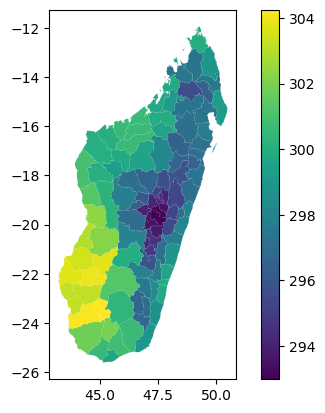

In [93]:
# # plot the result: for debugging purposes
        # import matplotlib.pyplot as plt
# convert to geopandas for image
gdf = gpd.GeoDataFrame(df, geometry=shape.geometry.values, crs=shape.crs)
gdf.plot(column="temp_vals", legend=True)
plt.show()

New pipeline approach: a single tiff file for each day-variable

Now that we've demonstrated how this could work, 